In [ ]:
from agentslab.utils.device import resolve_device
from agentslab.utils.seeding import set_global_seed
from pathlib import Path

device = resolve_device()

seed = 42
set_global_seed(seed, deterministic=True)

ROOT = Path('..').resolve()
ALGO_NAME, ENV_NAME = "ppo", "navigation"
SCENARIO_NAME = "navigation"

In [2]:
# DRAFT
%load_ext tensorboard

from agentslab.utils.logger import LoggerConfig
from agentslab.utils.checkpointers import CheckpointConfig


ImportError: cannot import name 'LoggerConfig' from 'agentslab.utils.logger' (C:\Users\ordevoir\Documents\GitHub\AgentsLab\src\agentslab\utils\logger.py)

In [4]:
# Создание среды
from agentslab.envs.vmas_factory import VMASConfig, make_vmas_env
from agentslab.utils.specs import print_specs

# Конфигурация среды
frames_per_batch = 6000
max_steps = 100
num_envs = frames_per_batch // max_steps

env_cfg = VMASConfig(
    scenario="navigation",
    n_agents=3,
    continuous_actions=True,
    max_steps=max_steps,
    num_envs=num_envs,
    device=device,
    sum_reward=True,
)
env = make_vmas_env(env_cfg)
# print_specs(env)

In [ ]:
# Cell 2: Среда, сети, политика
import torch
from agentslab.modules.networks import MultiAgentMLP, MultiAgentMLPConfig
from agentslab.modules.policy import build_gaussian_tanh_actor, StochasticPolicyConfig
from agentslab.modules.value import build_value_module, ValueHeadConfig

# Сети
obs_dim = env.observation_spec["agents","observation"].shape[-1]
act_dim = env.action_spec["agents","action"].shape[-1]

pi_net = MultiAgentMLP(MultiAgentMLPConfig(
    n_agents=env.n_agents, 
    in_per_agent=obs_dim, 
    out_per_agent=2*act_dim,
    hidden=256, 
    depth=2, 
    activation=torch.nn.Tanh, 
    centralised=False, 
    share_params=True
)).to(device)

vf_net = MultiAgentMLP(MultiAgentMLPConfig(
    n_agents=env.n_agents, in_per_agent=obs_dim, out_per_agent=1,
    hidden=256, depth=2, activation=torch.nn.Tanh, centralised=True, share_params=True
)).to(device)

# Политика и критик
policy = build_gaussian_tanh_actor(
    body=pi_net,
    action_spec=env.action_spec,
    cfg=StochasticPolicyConfig(action_key=env.action_key, obs_key=("agents","observation"))
).to(device)

critic = build_value_module(
    body=vf_net,
    cfg=ValueHeadConfig(in_key=("agents","observation"), out_key=("agents","state_value"))
).to(device)

policy, critic


Observation: Composite(
    agents: Composite(
        observation: UnboundedContinuous(
            shape=torch.Size([60, 3, 18]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([60, 3, 18]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([60, 3, 18]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            domain=continuous),
        info: Composite(
            pos_rew: UnboundedContinuous(
                shape=torch.Size([60, 3, 1]),
                space=ContinuousBox(
                    low=Tensor(shape=torch.Size([60, 3, 1]), device=cpu, dtype=torch.float32, contiguous=True),
                    high=Tensor(shape=torch.Size([60, 3, 1]), device=cpu, dtype=torch.float32, contiguous=True)),
                device=cpu,
                dtype=torch.float32,
                domain=continuous),
            final_rew: UnboundedContinuous(
     

(ProbabilisticActor(
     module=ModuleList(
       (0): TensorDictModule(
           module=Sequential(
             (0): MultiAgentMLP(
               (core): Sequential(
                 (0): Linear(in_features=18, out_features=256, bias=True)
                 (1): Tanh()
                 (2): Linear(in_features=256, out_features=256, bias=True)
                 (3): Tanh()
                 (4): Linear(in_features=256, out_features=4, bias=True)
               )
             )
             (1): NormalParamExtractor(
               (scale_mapping): biased_softplus()
             )
           ),
           device=cpu,
           in_keys=[('agents', 'observation')],
           out_keys=[('agents', 'loc'), ('agents', 'scale')])
       (1): SafeProbabilisticModule(
           in_keys=[('agents', 'loc'), ('agents', 'scale')],
           out_keys=[('agents', 'action'), ('agents', 'action_log_prob')],
           distribution_class=<class 'torchrl.modules.distributions.continuous.TanhNormal'

In [3]:

# Cell 3: Конфигурирование trainer и запуск
from agentslab.runners.trainers import train_marl_ppo, TrainerConfig
from agentslab.runners.objectives import PPOLossKeys, PPOConfig
from agentslab.modules.estimators import GAEConfig
from agentslab.storage.collectors import CollectorConfig
from agentslab.storage.buffers import BufferConfig
from agentslab.utils.logger import LoggerConfig
from agentslab.utils.checkpointers import CheckpointConfig

# Ключи
keys = PPOLossKeys(
    reward_key=("agents","reward"),
    action_key=env.action_key,
    value_key=("agents","state_value"),
    done_key=("agents","done"),
    terminated_key=("agents","terminated"),
)

# Конфиги
trainer_cfg = TrainerConfig(num_epochs=30, minibatch_size=400, lr=3e-4, max_grad_norm=1.0, save_every=1)
gae_cfg = GAEConfig(gamma=0.99, lmbda=0.9)
ppo_cfg = PPOConfig(clip_epsilon=0.2, entropy_coef=1e-4, normalize_advantage=False)
collector_cfg = CollectorConfig(frames_per_batch=frames_per_batch, total_frames=frames_per_batch*5)
buffer_cfg = BufferConfig(size=frames_per_batch, batch_size=trainer_cfg.minibatch_size)
ckpt_cfg = CheckpointConfig(dir="checkpoints", env_name=f"vmas-{env_cfg.scenario}", algo="PPO-MARL", seed=seed_cfg.seed)
logger_cfg = LoggerConfig(log_dir="logs", run_name=None, use_tb=True)

res = train_marl_ppo(
    env=env,
    policy=policy,
    critic=critic,
    keys=keys,
    trainer_cfg=trainer_cfg,
    gae_cfg=gae_cfg,
    ppo_cfg=ppo_cfg,
    buffer_cfg=buffer_cfg,
    collector_cfg=collector_cfg,
    ckpt_cfg=ckpt_cfg,
    logger_cfg=logger_cfg,
    device_model=devices["model"],
    device_storage=devices["storage"],
)
res


c:\Users\ordevoir\miniconda3\envs\marl\Lib\site-packages\torchrl\objectives\ppo.py:450: DeprecationWarning: 'entropy_coef' is deprecated and will be removed in torchrl v0.11. Please use 'entropy_coeff' instead.
  warnings.warn(


Collect/Train:   0%|          | 0/5 [00:00<?, ?it/s]

{'run_dir': 'checkpoints\\PPO-MARL-vmas-navigation-seed0-20250819-112840',
 'logger_dir': 'logs\\run-20250819-112840'}

In [4]:

# Cell 4: Оценка модели
from agentslab.runners.evals import evaluate_policy
metrics = evaluate_policy(env, policy, episodes=5)
metrics


Eval:   0%|          | 0/5 [00:00<?, ?it/s]

{'reward_mean': 0.0}

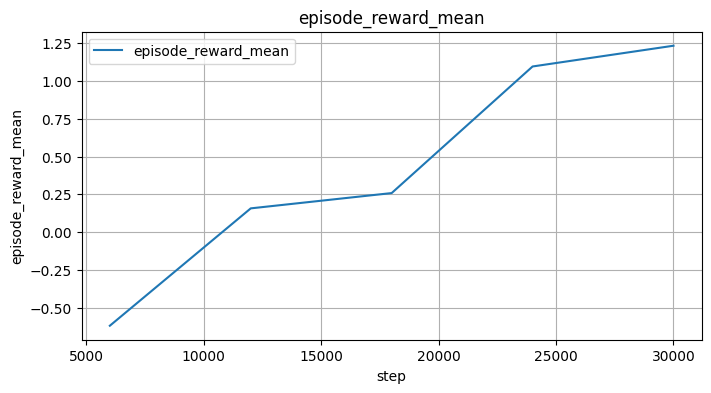

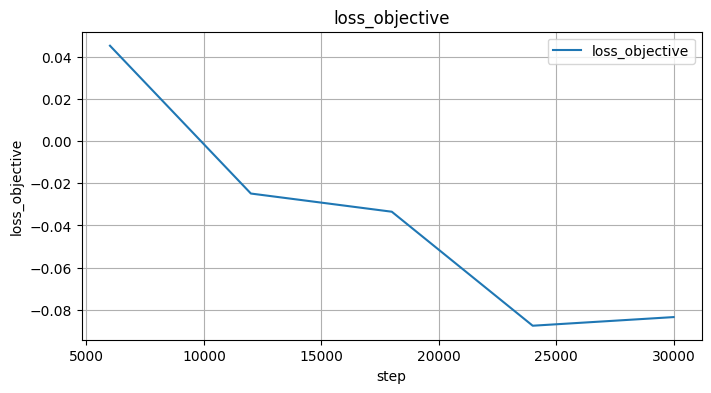

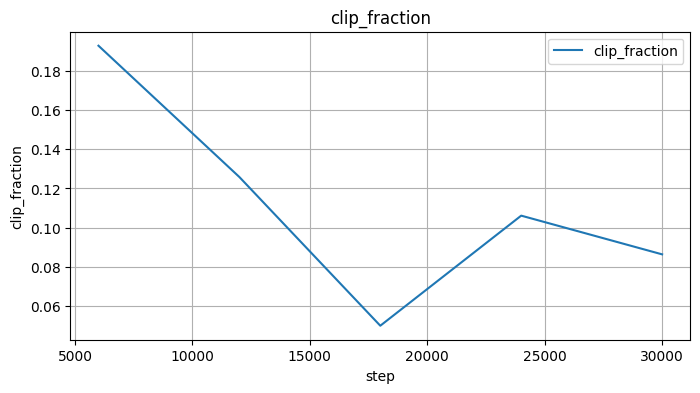

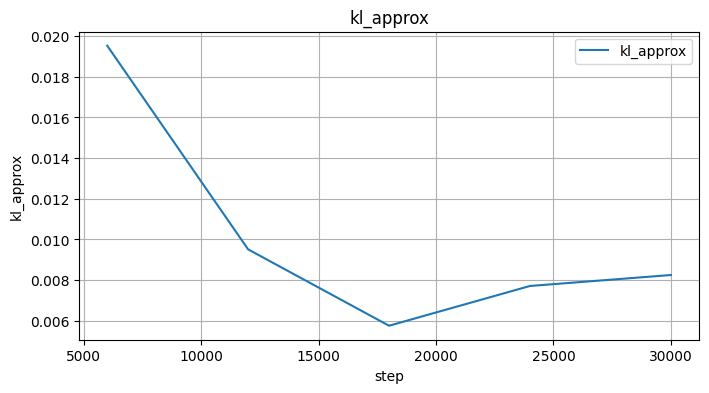

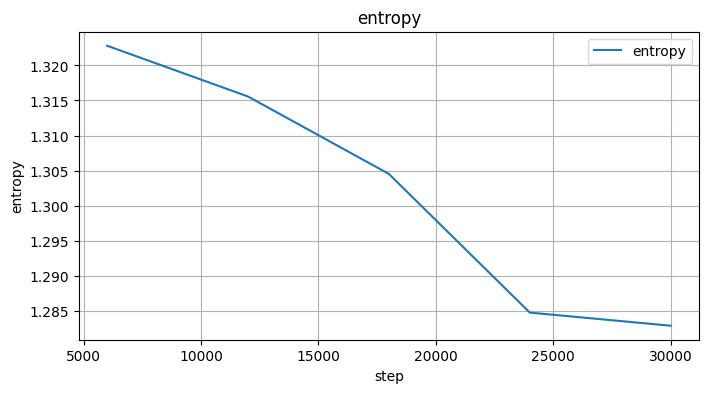

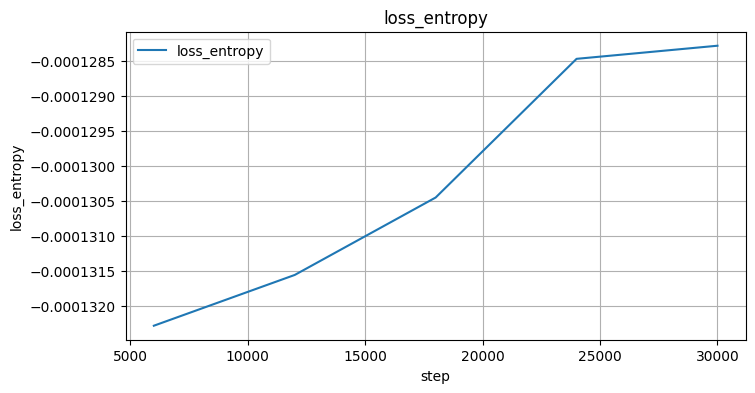

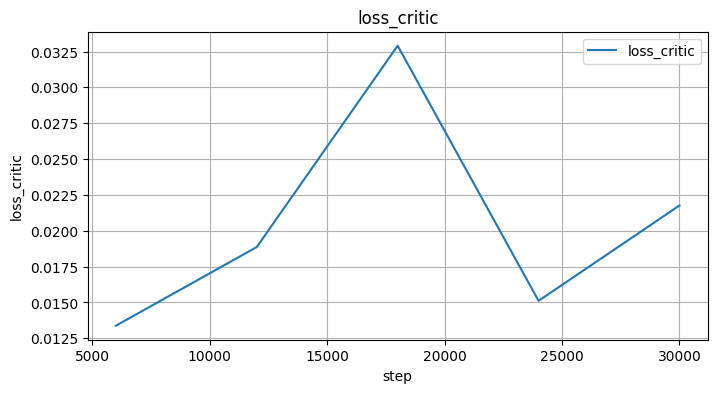

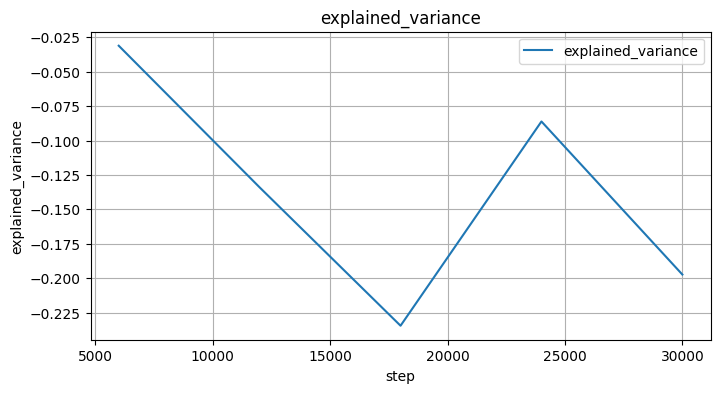

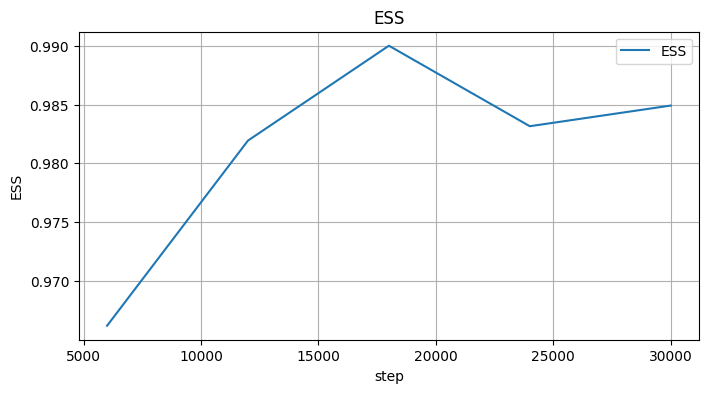

In [5]:

# Cell 5: Графики по логам
from agentslab.utils.curves import plot_metrics, PlotConfig
import os
log_dir = res["logger_dir"]
csv_path = os.path.join(log_dir, "metrics.csv")
plot_metrics(PlotConfig(log_path=csv_path, rolling=1))


In [6]:

# Cell 6: Визуализация (если поддерживается)
try:
    _ = env.set_seed(0)  # reset seed if available
    td = env.reset()
    for _ in range(3):
        td = policy(td)
        td = env.step(td)
        if ("pixels",) in td.keys(True, True):
            import matplotlib.pyplot as plt
            plt.imshow(td.get(("pixels",)).cpu().numpy())
            plt.axis("off")
            plt.show()
except Exception as e:
    print("Render not supported in this env:", e)


In [7]:

# Cell 7: Восстановление модели
import torch, os, glob
from agentslab.utils.checkpointers import latest_checkpoint

ckpt = latest_checkpoint(res["run_dir"])
print("Loading:", ckpt)
state = torch.load(ckpt, map_location=devices["model"])
policy.load_state_dict(state["policy"])
critic.load_state_dict(state["critic"])
print("Restored.")


Loading: checkpoints\PPO-MARL-vmas-navigation-seed0-20250819-112840\ckpt_00030000.pt
Restored.
